In [1]:
import pandas as pd
df = pd.read_csv("leavemng.machine-attandances.csv")
df.head()

_id  employeeId  machineId  login  location.latitude  \
0  65868bee14370b3a22f6bab8    10002037       1001  False          24.402130   
1  65868ec214370b3a22f6bb15    10002010       1001  False          24.402100   
2  658694ac14370b3a22f6bb40    10002037       1001  False          24.402198   
3  6586964a14370b3a22f6bb68    10002010       1001  False          24.402203   
4  658bc63487b29a789b492286    10002037       1001  False          24.430696   

   location.longitude                                             selfie  \
0           56.666842  1703316462543-85183742-4601-4fd5-94ce-f93f7e44...   
1           56.666855  1703317186271-203849fb-cba5-4dbf-97f2-14bb5f94...   
2           56.666801  1703318699669-d29cee40-9f33-4827-a4fc-597b6efa...   
3           56.666710  1703319113670-422f7d77-9832-4c10-ac1f-38de4df9...   
4           56.576431  1703659059806-f54239f1-6cb6-4fc0-a22a-3a3e0828...   

                      loginAt  isCompleted  __v  
0  2023-12-23T11:27:36.495887        False    0  
1  2023-12-23T11:39:40.606083        False    0  
2  2023-12-23T12:04:43.049688         True    0  
3  2023-12-23T12:11:42.454649         True    0  
4  2023-12-27T10:37:34.167756        False    0

In [2]:
df["loginAt"] = pd.to_datetime(df["loginAt"])

In [3]:
df["Date"]=df["loginAt"].dt.date

In [4]:
# Group by year_month and count unique employeeIds
employee_count = df.groupby('Date')['employeeId'].nunique().reset_index()

In [5]:
employee_count

Date  employeeId
0    2023-12-23           3
1    2023-12-27           1
2    2023-12-28          10
3    2023-12-29           7
4    2023-12-30           5
..          ...         ...
260  2024-09-12         537
261  2024-09-13         532
262  2024-09-14         536
263  2024-09-15         260
264  2024-09-16          40

[265 rows x 2 columns]

In [11]:
employee_count.set_index('Date', inplace=True)

In [13]:
employee_count.isna().sum()

employeeId    0
dtype: int64

In [25]:
import numpy as np
mean = np.mean(employee_count['emp_Boxcox'])
std_dev = np.std(employee_count['emp_Boxcox'])

z_scores = [(x - mean) / std_dev for x in employee_count['emp_Boxcox']]
outliers = [data[i] for i in range(len(z_scores)) if np.abs(z_scores[i]) > 3]
print("Outliers using Z-score:", outliers)

Outliers using Z-score: []


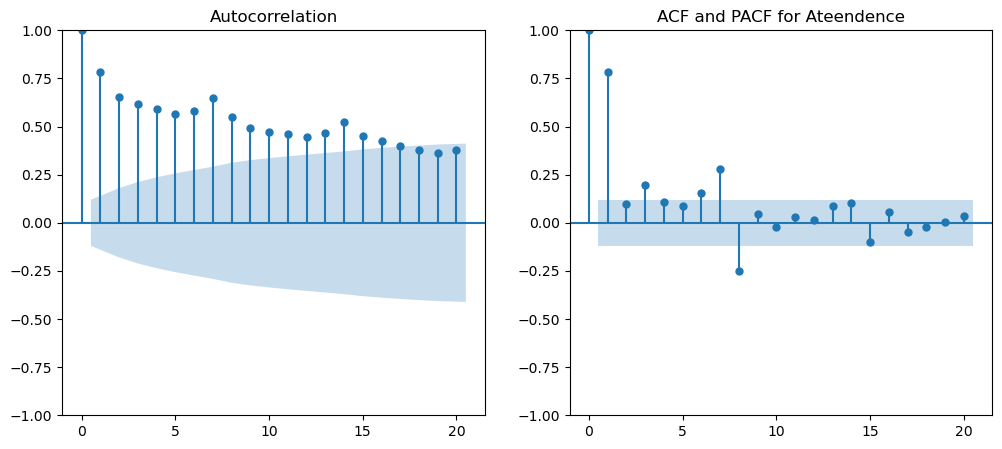

In [19]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
# ACF and PACF plots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sm.graphics.tsa.plot_acf(employee_count, lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(employee_count, lags=20, ax=ax[1])
plt.title(f'ACF and PACF for Ateendence')
plt.show()

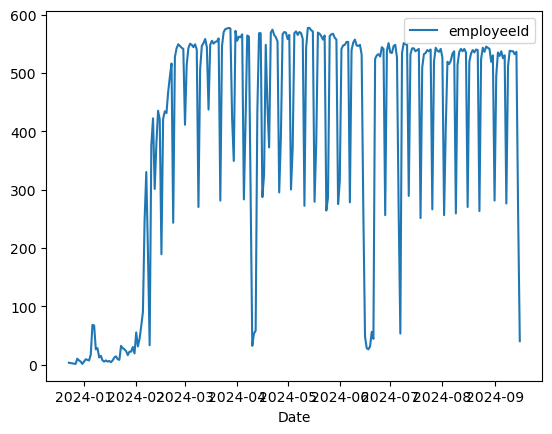

In [21]:
 from matplotlib import pyplot  
# plotting the time series  
employee_count.plot()  
pyplot.show()  

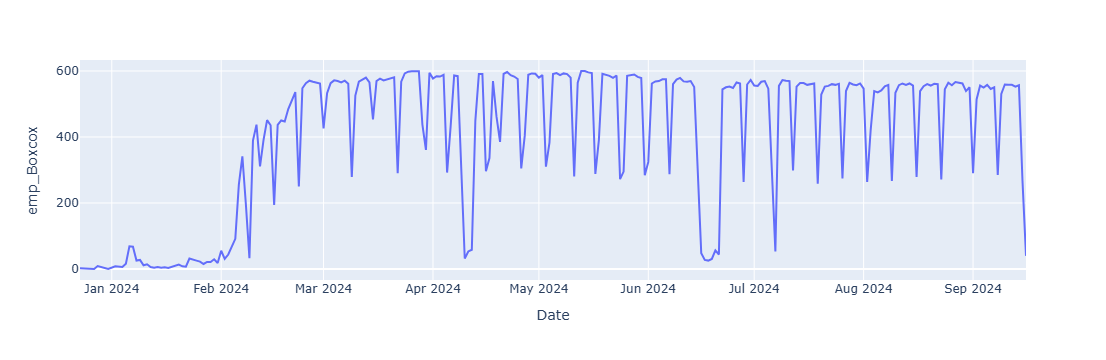

In [23]:
# Import packages 
from scipy.stats import boxcox

# Make the target variance stationary
employee_count['emp_Boxcox'], lam = boxcox(employee_count['employeeId'])
import plotly.express as px
# Plot the box-cox passenger data
px.line(employee_count, y='emp_Boxcox')

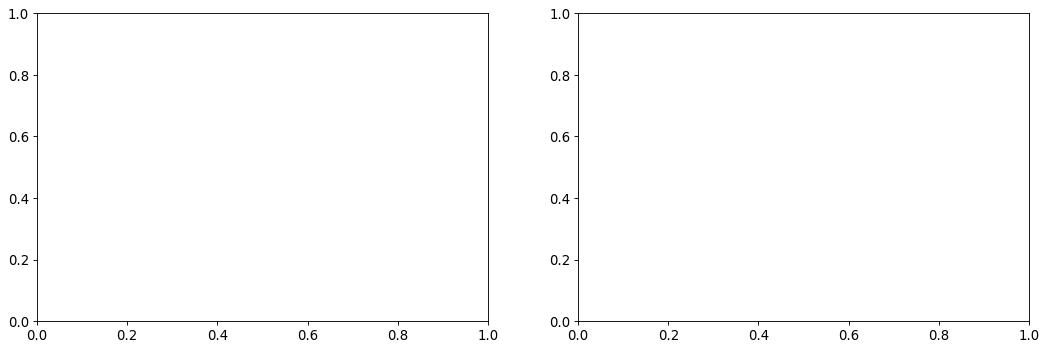

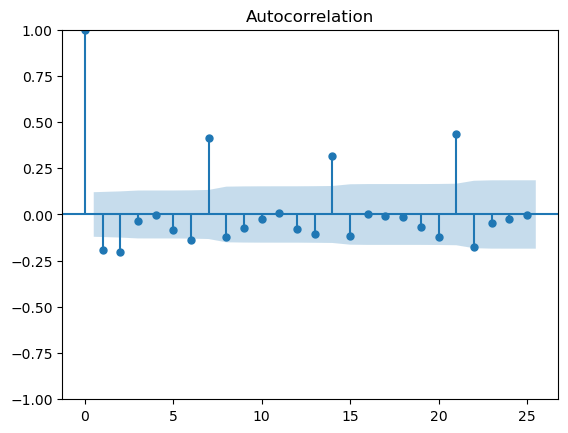

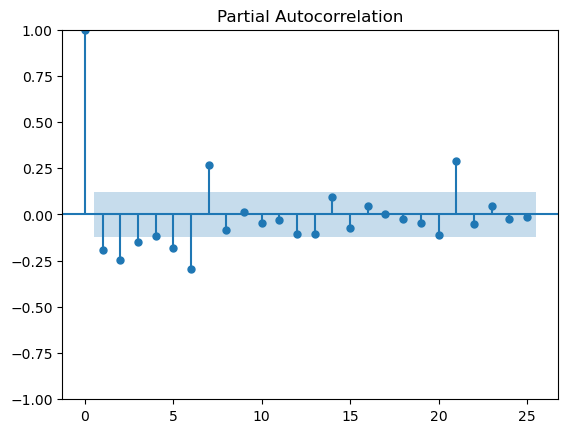

In [27]:
# Import packages
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Difference the data
employee_count["emp_diff"] = employee_count["emp_Boxcox"].diff()
employee_count.dropna(inplace=True)

# Plot acf and pacf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
plot_acf(employee_count['emp_diff'])
plot_pacf(employee_count['emp_diff'], method='ywm')
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

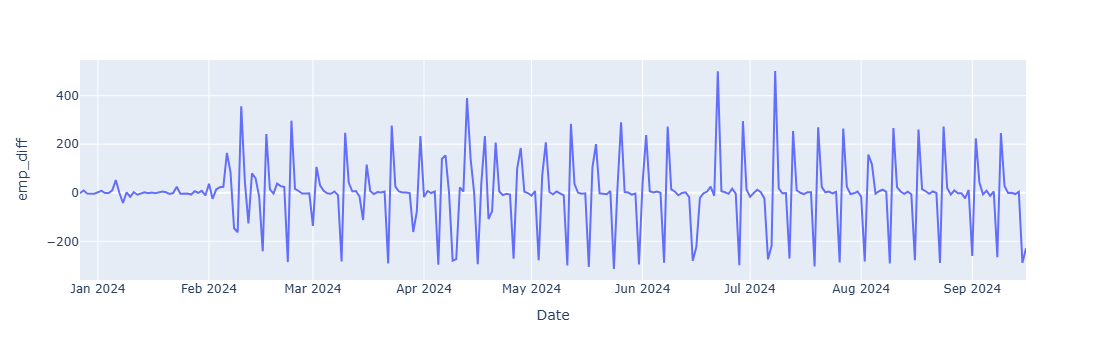

In [29]:
px.line(employee_count, y='emp_diff')

In [31]:
# Import packages
from statsmodels.tsa.arima.model import ARIMA
from scipy.special import inv_boxcox

# Split train and test
train = employee_count.iloc[:-int(len(employee_count) * 0.2)]
test = employee_count.iloc[-int(len(employee_count) * 0.2):]

# Build ARIMA model and inverse the boxcox
model = ARIMA(train['emp_Boxcox'], order=(12, 1, 12)).fit()
boxcox_forecasts = model.forecast(len(test))
forecasts = inv_boxcox(boxcox_forecasts, lam)

C:\Users\Fafcom\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\Fafcom\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\Fafcom\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\Fafcom\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Fafcom\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be giv

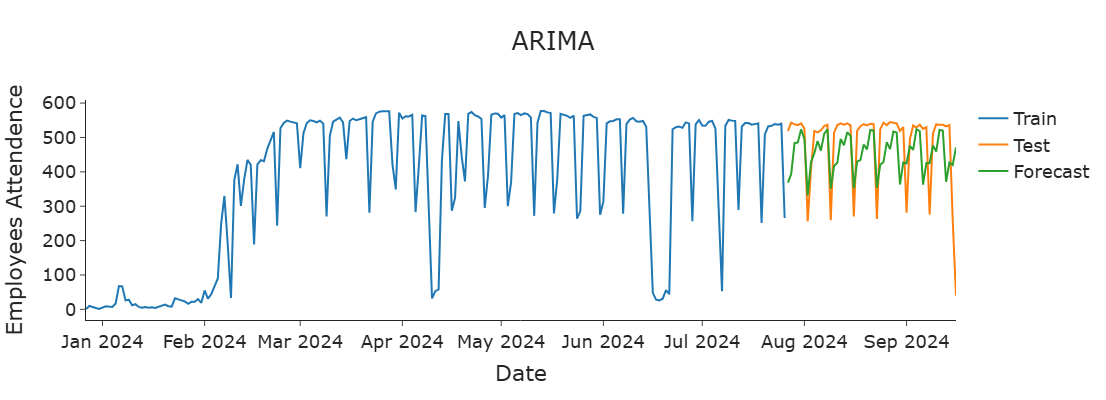

In [32]:
# Import packages
import plotly.graph_objects as go

def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['employeeId'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['employeeId'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Employees Attendence')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'ARIMA')

In [33]:
import pmdarima as pm
# Fit the auto ARIMA model
model1 = pm.auto_arima(train['emp_Boxcox'], 
                       seasonal=False,     # Set to True if you have seasonal data
                       stepwise=True, 
                       trace=True,
                      stationary=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2907.445, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2677.655, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2769.652, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3195.636, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2678.632, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2677.370, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2664.983, Time=0.62 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2661.848, Time=0.70 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=2671.122, Time=0.39 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=2663.841, Time=0.69 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=2670.474, Time=0.48 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=2668.709, Time=0.82 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2

In [34]:
boxcox_forecasts = model1.predict(len(test))

# Inverse Box-Cox transformation on the forecasts
forecasts1 = inv_boxcox(boxcox_forecasts, lam)

C:\Users\Fafcom\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\Fafcom\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



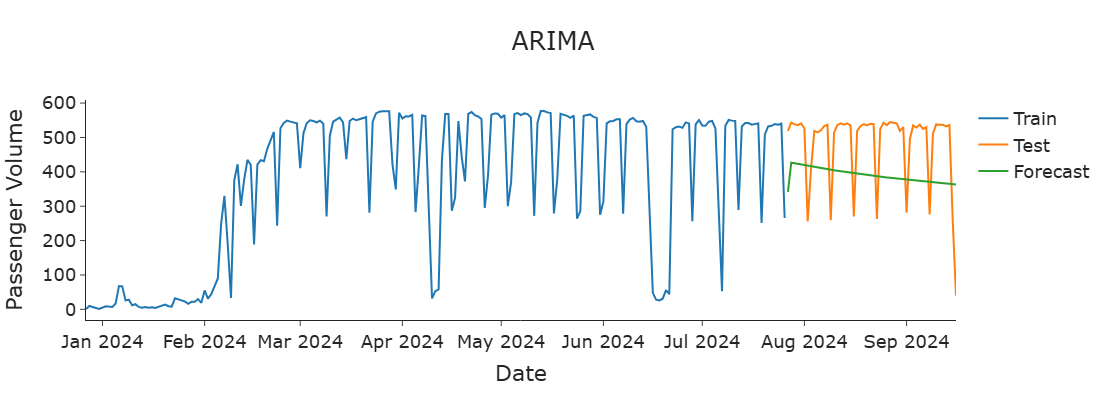

In [35]:
# Import packages
import plotly.graph_objects as go

def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['employeeId'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['employeeId'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Employees attendence')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts1, 'ARIMA')

In [36]:
# Import packages
from scipy.special import inv_boxcox
from statsmodels.tsa.arima.model import ARIMA

# Build ARIMA model
model2 = ARIMA(train['emp_Boxcox'], order=(10, 1, 10),
              seasonal_order=(1, 1, 1, 12)).fit()
boxcox_forecasts = model2.forecast(len(test))
forecasts2 = inv_boxcox(boxcox_forecasts, lam)

C:\Users\Fafcom\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\Fafcom\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\Fafcom\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\Fafcom\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Fafcom\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be giv

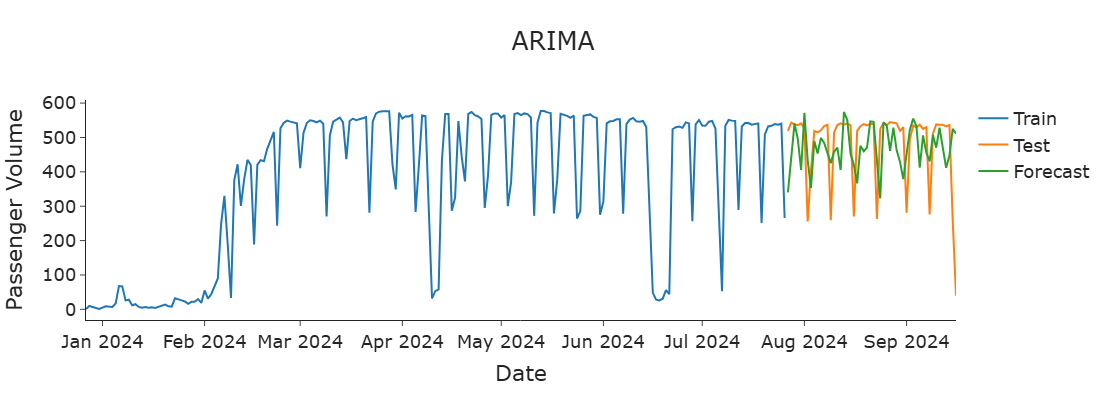

In [37]:
# Import packages
import plotly.graph_objects as go

def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['employeeId'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['employeeId'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Employees attendence')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts2, 'ARIMA')

In [45]:
from prophet import Prophet
from prophet.plot import plot_plotly
import plotly.offline as py

In [47]:
employee_count.reset_index(inplace=True)
employee_count.head()

Date  employeeId  emp_Boxcox  emp_diff
0  2023-12-27           1    0.000000 -2.009877
1  2023-12-28          10    9.107313  9.107313
2  2023-12-29           7    6.058244 -3.049068
3  2023-12-30           5    4.030897 -2.027347
4  2023-12-31           1    0.000000 -4.030897

In [49]:
employee_count = employee_count.rename(columns={'Date': 'ds',
                        
                        'employeeId': 'y'})

col = [
    "ds",
    "y"
]
df1 = employee_count[col].copy()
df1.head()

ds   y
0  2023-12-27   1
1  2023-12-28  10
2  2023-12-29   7
3  2023-12-30   5
4  2023-12-31   1

In [51]:
train = employee_count.iloc[:-int(len(df1) * 0.2)]
test = employee_count.iloc[-int(len(df1) * 0.2):]

In [103]:
import pandas as pd
from hijri_converter import convert
from datetime import datetime

def get_eid_dates(year):
    """Function to calculate Eid dates using Hijri Converter."""
    # Approximate dates for Eid al-Fitr and Eid al-Adha
    eid_fitr = convert.Hijri(1445, 10, 1).to_gregorian()  # Example for Eid al-Fitr in 2024
    eid_adha = convert.Hijri(1445, 12, 10).to_gregorian()  # Example for Eid al-Adha in 2024
    return eid_fitr, eid_adha

# Generate holidays for multiple years
years = [2024, 2025, 2026]
holidays_list = []

for year in years:
    eid_fitr, eid_adha = get_eid_dates(year)
    holidays_list.extend([
        {'holiday': 'Eid al-Fitr', 'ds': eid_fitr, 'lower_window': 0, 'upper_window': 1},
        {'holiday': 'Eid al-Adha', 'ds': eid_adha, 'lower_window': 0, 'upper_window': 1},
        {'holiday': 'National Day', 'ds': datetime(year, 11, 18), 'lower_window': 0, 'upper_window': 1},
        # Add other holidays as needed
    ])

# Convert the list to a DataFrame
oman_holidays_df = pd.DataFrame(holidays_list)

In [ ]:
# Add a 'day_of_week' column
train['day_of_week'] = train['ds'].dt.dayofweek  # 0 = Monday, 4 = Friday

In [291]:
my_model = Prophet(interval_width=0.95,holidays=oman_holidays_df)
my_model.add_seasonality(name='friday_effect', period=7, fourier_order=2, prior_scale=10)
my_model.fit(train)

00:52:59 - cmdstanpy - INFO - Chain [1] start processing
00:52:59 - cmdstanpy - INFO - Chain [1] done processing


In [293]:
boxcox_forecasts = my_model.predict(test)
boxcox_forecasts

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2024-07-27  494.099495  195.716295  693.099805   493.990163   494.199040   
1  2024-07-28  494.291686  274.377087  765.637858   493.931206   494.617472   
2  2024-07-29  494.483877  292.548558  797.244380   493.728178   495.134646   
3  2024-07-30  494.676067  270.420389  759.887797   493.516324   495.719217   
4  2024-07-31  494.868258  278.557457  754.747284   493.260636   496.453194   
5  2024-08-01  495.060449  281.375307  783.656593   492.825631   497.041396   
6  2024-08-02  495.252640  133.516707  611.013508   492.489717   497.731887   
7  2024-08-03  495.444831  214.585341  686.851311   492.170839   498.399327   
8  2024-08-04  495.637022  290.311415  773.236087   491.838280   499.106184   
9  2024-08-05  495.829213  320.838728  794.643452   491.333746   499.935834   
10 2024-08-06  496.021404  273.017895  754.247610   490.968984   500.903114   
11 2024-08-07  496.213595  285.842474  770.832864   490.585671   501.668926   
12 2024-08-08  496.405786  291.179025  793.779112   490.301469   502.465639   
13 2024-08-09  496.597977  122.723171  596.875569   489.872008   503.777102   
14 2024-08-10  496.790168  230.220382  676.382542   489.434838   504.801708   
15 2024-08-11  496.982359  283.779587  788.929656   488.863324   505.652733   
16 2024-08-12  497.174550  314.366287  808.751712   488.640649   506.562659   
17 2024-08-13  497.366741  275.632206  753.870070   488.026849   507.672054   
18 2024-08-14  497.558932  286.679313  774.193540   487.497198   508.528705   
19 2024-08-15  497.751123  282.186827  769.130531   486.951541   509.381951   
20 2024-08-16  497.943314  124.486161  607.771754   486.319622   510.235197   
21 2024-08-17  498.135505  198.101741  702.636858   485.576083   511.271640   
22 2024-08-18  498.327696  301.802745  769.637166   484.900883   512.086379   
23 2024-08-19  498.519887  315.964399  780.891177   484.147988   513.353744   
24 2024-08-20  498.712078  302.516626  772.855801   483.652138   514.581352   
25 2024-08-21  498.904269  286.549495  790.345368   482.887496   516.114211   
26 2024-08-22  499.096460  282.211289  794.360566   482.176353   517.080656   
27 2024-08-23  499.288651  107.446694  594.853005   481.499945   518.314024   
28 2024-08-24  499.480842  197.555632  689.161053   480.825379   519.837023   
29 2024-08-25  499.673033  290.748853  779.858688   480.152654   521.222048   
30 2024-08-26  499.865224  312.751955  793.180085   479.275274   522.463000   
31 2024-08-27  500.057415  290.609191  755.376900   478.467680   523.343723   
32 2024-08-28  500.249606  287.885900  765.497222   477.779701   524.270333   
33 2024-08-29  500.441797  312.279623  778.678663   477.103406   525.379864   
34 2024-08-30  500.633988  116.478384  612.200851   476.417354   526.821409   
35 2024-08-31  500.826179  215.908975  686.494329   475.452315   528.505465   
36 2024-09-01  501.018370  302.631114  803.815810   474.892088   529.704499   
37 2024-09-02  501.210561  279.785972  799.488658   473.827571   531.146044   
38 2024-09-03  501.402752  283.664619  756.542376   472.973711   532.369499   
39 2024-09-04  501.594943  300.873921  770.876085   472.222904   533.480218   
40 2024-09-05  501.787134  269.952898  769.339013   471.267316   534.589522   
41 2024-09-06  501.979325  115.704627  617.173754   470.175254   535.697409   
42 2024-09-07  502.171516  200.629297  705.670885   469.012829   536.805296   
43 2024-09-08  502.363707  308.979747  778.161531   467.976070   537.941776   
44 2024-09-09  502.555898  318.514246  793.114524   466.967340   539.440017   
45 2024-09-10  502.748088  287.584246  767.808407   466.070987   540.946263   
46 2024-09-11  502.940279  304.071820  785.639023   464.935634   542.453366   
47 2024-09-12  503.132470  280.145059  786.898405   464.117832   543.947801   
48 2024-09-13  503.324661  120.249642  620.260751   463.253352   545.442236   
49 2024-09-14  503.516852  215.511200  699.006673   462.56290

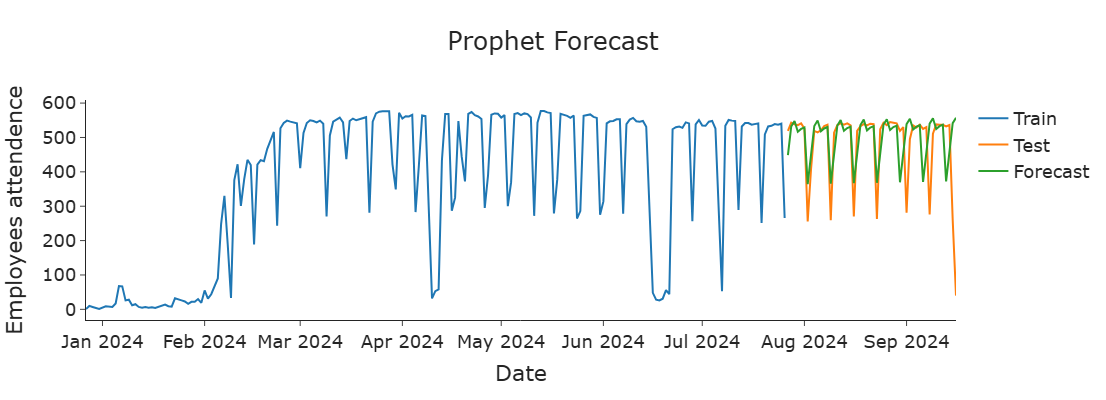

In [295]:
import plotly.graph_objects as go

def plot_forecasts(train, test, forecasts, title: str) -> None:
    """Function to plot the Prophet forecasts."""
    fig = go.Figure()
    
    # Plot the training data
    fig.add_trace(go.Scatter(x=train['ds'], y=train['y'], mode='lines', name='Train'))
    
    # Plot the test data
    fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], mode='lines', name='Test'))
    
    # Plot the forecast
    fig.add_trace(go.Scatter(x=forecasts['ds'], y=forecasts['yhat'], mode='lines', name='Forecast'))
    
    # Optionally, you can plot confidence intervals as well
    # fig.add_trace(go.Scatter(
    #     x=forecasts['ds'], y=forecasts['yhat_lower'], mode='lines', 
    #     line=dict(width=0), name='Lower Confidence', showlegend=False
    # ))
    
    # # fig.add_trace(go.Scatter(
    # #     x=forecasts['ds'], y=forecasts['yhat_upper'], mode='lines', 
    # #     fill='tonexty', name='Confidence Interval', showlegend=False
    # ))
    
    # Update layout
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Employees attendence')

    fig.show()

# Example usage
# Assuming `train`, `test`, and `boxcox_forecasts` are DataFrames with proper Prophet format
plot_forecasts(train, test, boxcox_forecasts, 'Prophet Forecast')


In [417]:
import pickle

# Assuming `model` is your trained Prophet model
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(my_model, f)


In [415]:
df_cv = cross_validation(my_model, initial='30 days', period='30 days', horizon='30 days')
metrics = performance_metrics(df_cv)

# Print performance metrics
print(metrics)

  0%|          | 0/6 [00:00<?, ?it/s]

02:23:00 - cmdstanpy - INFO - Chain [1] start processing
02:23:01 - cmdstanpy - INFO - Chain [1] done processing
02:23:01 - cmdstanpy - INFO - Chain [1] start processing
02:23:02 - cmdstanpy - INFO - Chain [1] done processing
02:23:03 - cmdstanpy - INFO - Chain [1] start processing
02:23:04 - cmdstanpy - INFO - Chain [1] done processing
02:23:05 - cmdstanpy - INFO - Chain [1] start processing
02:23:05 - cmdstanpy - INFO - Chain [1] done processing
02:23:05 - cmdstanpy - INFO - Chain [1] start processing
02:23:05 - cmdstanpy - INFO - Chain [1] done processing
02:23:06 - cmdstanpy - INFO - Chain [1] start processing
02:23:06 - cmdstanpy - INFO - Chain [1] done processing


   horizon            mse        rmse         mae      mape     mdape  \
0   3 days    9332.609083   96.605430   62.687365  0.195532  0.163427   
1   4 days    9992.383147   99.961908   68.163593  0.235333  0.173718   
2   5 days    6758.708083   82.211362   61.417038  0.215297  0.141235   
3   6 days    8850.923882   94.079349   73.616918  0.257614  0.188427   
4   7 days    9712.501513   98.552024   78.148806  0.253995  0.206996   
5   8 days   13541.166707  116.366519   83.567893  0.296496  0.129495   
6   9 days   19292.614258  138.897855   99.201695  0.327340  0.079441   
7  10 days   25888.810392  160.900001  119.659996  0.366275  0.136746   
8  11 days   41131.424433  202.808837  162.238949  0.917735  0.305025   
9  12 days   44168.885609  210.163949  153.040844  0.928155  0.303765   
10 13 days   72382.774298  269.040470  177.953419  2.161470  0.222406   
11 14 days   91966.676762  303.260081  188.025365  2.353464  0.084087   
12 15 days  106256.635639  325.970299  213.340989  

In [387]:


model45 = Prophet(seasonality_prior_scale=20,
                  changepoint_prior_scale=0.5,
                  
                  yearly_seasonality=False,
                  )


model45.fit(train)

# Ensure your future DataFrame includes this regressor
future = model45.make_future_dataframe(periods=365)
future['external_variable'] = ...  # Add values for your external regressor
forecast = model45.predict(future)


01:13:35 - cmdstanpy - INFO - Chain [1] start processing
01:13:35 - cmdstanpy - INFO - Chain [1] done processing


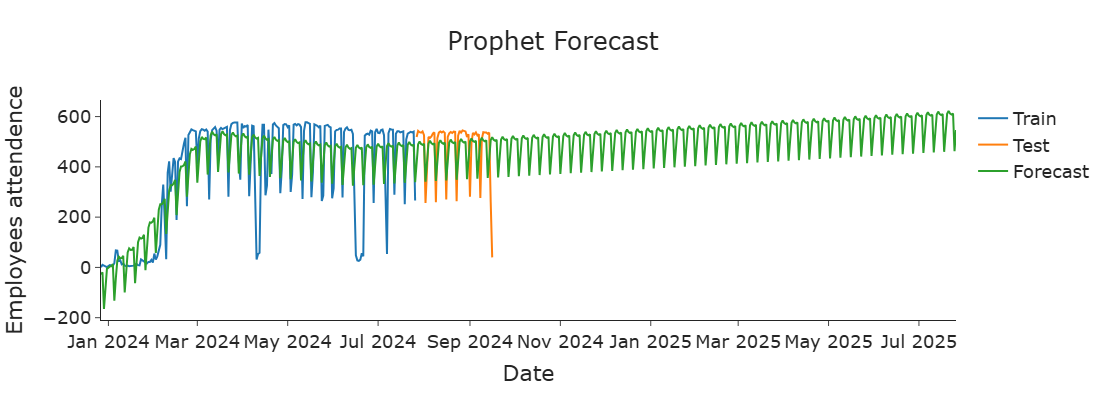

In [393]:
import plotly.graph_objects as go

def plot_forecasts(train, test, forecasts, title: str) -> None:
    """Function to plot the Prophet forecasts."""
    fig = go.Figure()
    
    # Plot the training data
    fig.add_trace(go.Scatter(x=train['ds'], y=train['y'], mode='lines', name='Train'))
    
    # Plot the test data
    fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], mode='lines', name='Test'))
    
    # Plot the forecast
    fig.add_trace(go.Scatter(x=forecasts['ds'], y=forecasts['yhat'], mode='lines', name='Forecast'))
    
    # Optionally, you can plot confidence intervals as well
    # fig.add_trace(go.Scatter(
    #     x=forecasts['ds'], y=forecasts['yhat_lower'], mode='lines', 
    #     line=dict(width=0), name='Lower Confidence', showlegend=False
    # ))
    
    # # fig.add_trace(go.Scatter(
    # #     x=forecasts['ds'], y=forecasts['yhat_upper'], mode='lines', 
    # #     fill='tonexty', name='Confidence Interval', showlegend=False
    # ))
    
    # Update layout
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Employees attendence')

    fig.show()

# Example usage
# Assuming `train`, `test`, and `boxcox_forecasts` are DataFrames with proper Prophet format
plot_forecasts(train, test, forecast, 'Prophet Forecast')


02:13:11 - cmdstanpy - INFO - Chain [1] start processing
02:13:11 - cmdstanpy - INFO - Chain [1] done processing


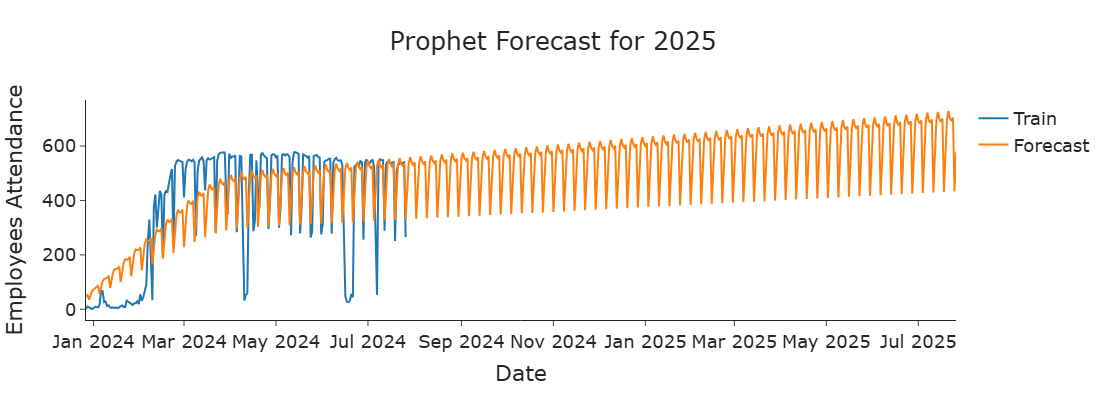

  0%|          | 0/1 [00:00<?, ?it/s]

02:13:13 - cmdstanpy - INFO - Chain [1] start processing
02:13:13 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse        rmse         mae      mape     mdape  \
0   3 days   7699.908274   87.749121   82.086094  0.228074  0.179221   
1   4 days   7407.679870   86.067879   77.551177  0.219407  0.179221   
2   5 days   3351.179870   57.889376   44.116597  0.081666  0.046130   
3   6 days    461.331516   21.478629   20.325983  0.037562  0.046130   
4   7 days    909.664324   30.160642   26.727210  0.049427  0.046908   
5   8 days   1506.087973   38.808349   37.752165  0.069390  0.079537   
6   9 days   9487.010277   97.401285   81.652096  0.153087  0.081724   
7  10 days  19625.127374  140.089712  126.783383  0.353138  0.298002   
8  11 days  94206.070442  306.930074  270.594143  3.314163  0.681875   
9  12 days  86032.682282  293.313284  220.702971  3.219246  0.681875   
10 13 days  75753.951208  275.234357  173.902364  3.015919  0.071893   
11 14 days   1220.321258   34.933097   30.624581  0.055816  0.071893   
12 15 days   1768.082430   42.048572   41.982869  0.076430  0.07

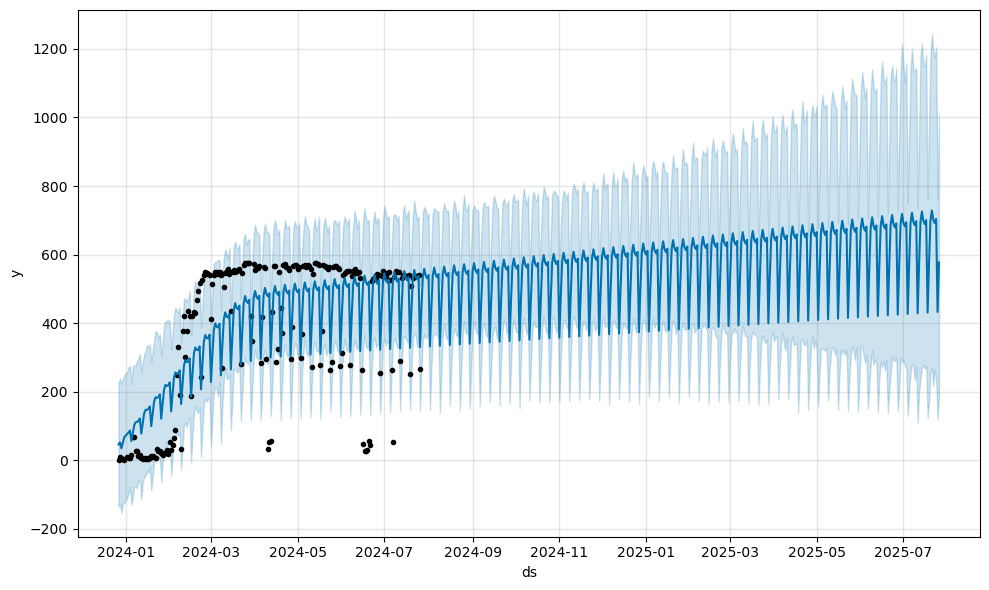

In [409]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import plotly.graph_objects as go

# Create a dataframe for holidays
holidays = pd.DataFrame({
    'holiday': 'friday_effect',
    'ds': pd.to_datetime(['2025-01-02', '2025-01-09', '2025-01-16', '2025-01-23']),
    'lower_window': 0,
    'upper_window': 1,
})

# Initialize and fit the model
model = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=False,
    daily_seasonality=False,
    holidays=holidays,
    seasonality_mode='multiplicative'
)

model.fit(train)

# Predict
future = model.make_future_dataframe(periods=365)  # Predicting for the next year
forecast = model.predict(future)

# Plot
model.plot(forecast)

# Step 5: Plot the forecasts
def plot_forecasts(train, forecast, title: str) -> None:
    """Function to plot the Prophet forecasts."""
    fig = go.Figure()

    # Plot the training data
    fig.add_trace(go.Scatter(x=train['ds'], y=train['y'], mode='lines', name='Train'))

    # Plot the forecast
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast'))

    # # Confidence intervals
    # fig.add_trace(go.Scatter(
    #     x=forecast['ds'], y=forecast['yhat_lower'], mode='lines',
    #     line=dict(width=0), name='Lower Confidence', showlegend=False
    # ))

    # fig.add_trace(go.Scatter(
    #     x=forecast['ds'], y=forecast['yhat_upper'], mode='lines',
    #     fill='tonexty', name='Confidence Interval', showlegend=False
    # ))

    # Update layout
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Employees Attendance')

    fig.show()

# Call the plot function
plot_forecasts(train, forecast, 'Prophet Forecast for 2025')

# Step 6: Cross-validation and performance metrics
df_cv = cross_validation(my_model33, initial='180 days', period='30 days', horizon='30 days')
metrics = performance_metrics(df_cv)

# Print performance metrics
print(metrics)